Monthly average of CO2 and CH4 data used for this project is from NOAA Global Monitoring Laboratory "https://gml.noaa.gov/data/data.php"

In this project I will study relation between CO2 (Carbon dioxide) and CH4 (Methane) greenhouse gases in baltic sea. I acquired this data from NOAA Global monitoring Laboratory. The time series were analyzed by smoothing the data using ccg filter and from this I also acquired seasonal change for both datasets. Pearson correlation was used to analyze correlation between these two gases and finally I used machine learning to test if CH4 data can be used to predict CO2

In [83]:
#Imported libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score

# NOAA GML custom modules
from ccgvu import ccg_dates  # Date utilities
from ccgvu import ccg_filter  # Data filtering and curve fitting

In [84]:
#Read Ch4 and CO2 emission data from baltic sea
ch4_filename = "ch4_baltic.txt"
co2_filename = "co2_baltic.txt"
ch4_data = pd.read_table(ch4_filename, header=None, sep = r'\s+', skiprows=53)
co2_data = pd.read_table(co2_filename, header=None, sep = r'\s+', skiprows=53)

In [85]:
#Read feature names from a file
def read_header_file(filename):
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("#") and "data_fields:" in line:
                cols = line.strip().split("data_fields:")[1].strip().split()
                break
    return cols

In [86]:
#Add the names to dataframe
ch4_data.columns = read_header_file(ch4_filename)
co2_data.columns = read_header_file(co2_filename)

In [87]:
#Exclude location of measurement from each row because data is only from baltic sea
ch4_data = ch4_data.iloc[: , 1:]
co2_data = co2_data.iloc[: , 1:]


In [88]:
#Add date to each dataset
ch4_data["date"] = pd.to_datetime(dict(year=ch4_data.year, month=ch4_data.month, day = 1))
co2_data["date"] = pd.to_datetime(dict(year=co2_data.year, month=co2_data.month, day = 1))

In [89]:
# combine CO2 and CH4 datasets
data = co2_data.merge(ch4_data, on=["year", "month", "date"], how="inner")
data = data.sort_values("date")
data = data.iloc[:, [3, 0, 1, 2, 4]]
data.columns = ["date", "year", "month", "co2", "ch4"]

In [90]:
display(data)

,date,year,month,co2,ch4
0,1992-09-01,1992,9,353.17,1846.87
1,1992-10-01,1992,10,359.98,1853.50
2,1992-11-01,1992,11,361.21,1850.97
3,1992-12-01,1992,12,360.48,1832.20
4,1993-01-01,1993,1,362.70,1828.41
...,...,...,...,...,...
208,2011-02-01,2011,2,400.03,1921.64
209,2011-03-01,2011,3,401.30,1918.01
210,2011-04-01,2011,4,397.96,1898.30
211,2011-05-01,2011,5,396.36,1895.60


In [91]:
#Add decimaltime to dataset for later use
data["decimaltime"] = data.apply(lambda row: row["year"] + row["month"]/12, axis=1)

In [92]:
# Create filter object using NOAA GML's curve fitting class
def apply_ccg_filter(xp, yp):
    filt = ccg_filter.ccgFilter(
        xp,  
        yp, 
        shortterm=80,  
        longterm=667,    
        sampleinterval=0,
        numpolyterms=3,      
        numharmonics=4,     
        timezero=-1,         
        gap=0,          
        use_gain_factor=False, 
        debug=False         
    )

    # Interpolated time grid
    x0 = filt.xinterp
    
    # Extract components
    smooth = filt.getSmoothValue(x0)
    trend = filt.getTrendValue(x0)
    seasonal = smooth - trend  # seasonal component
    
    # Convert to datetime
    dates = [ccg_dates.datetimeFromDecimalDate(x) for x in x0]
    
    # Build DataFrame
    df = pd.DataFrame({
        "date": dates,
        f"smooth": smooth,
        f"trend": trend,
        f"seasonal": seasonal
    })
    
    return df

In [93]:
co2_df = apply_ccg_filter(data["decimaltime"], data["co2"])
ch4_df = apply_ccg_filter(data["decimaltime"], data["ch4"])

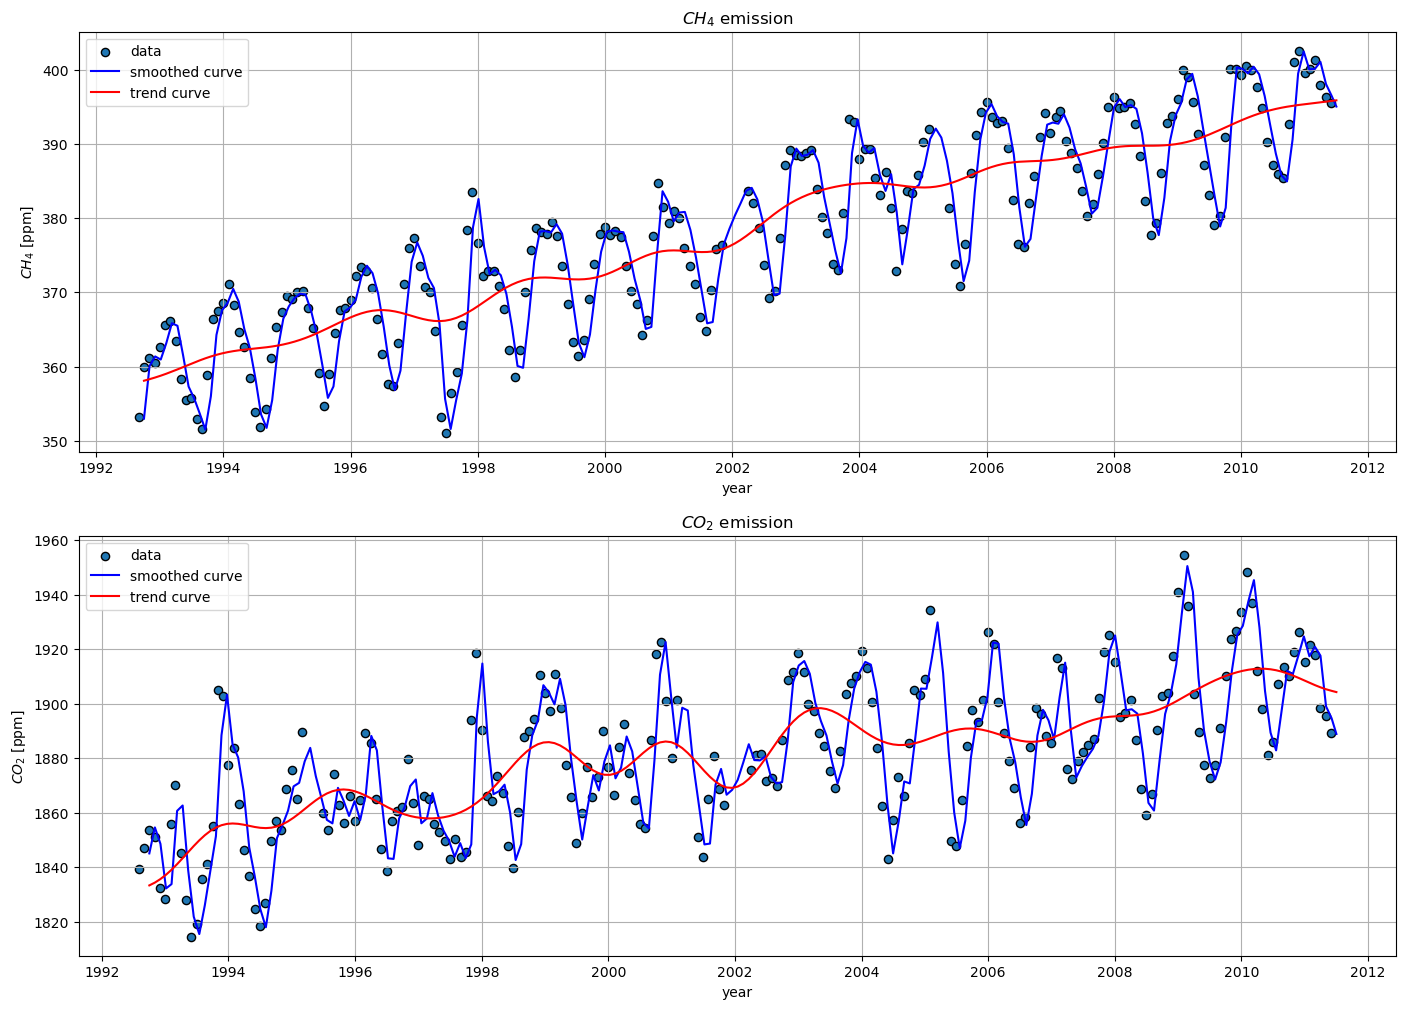

In [94]:
# Function fit and measured data fro CO2 and CH4
fig,ax = plt.subplots(2, figsize=(17,12))

ax[0].scatter(co2_data["date"], co2_data["value"], s=35, edgecolors= "black", label = "data")
ax[0].plot(co2_df["date"], co2_df["smooth"], c="blue", label= "smoothed curve")
ax[0].plot(co2_df["date"], co2_df["trend"], c="red", label = "trend curve")
ax[0].set_xlabel("year")
ax[0].set_ylabel("$CH_4$ [ppm]")
ax[0].set_title("$CH_4$ emission")
ax[0].grid()
ax[0].legend()

ax[1].scatter(ch4_data["date"], ch4_data["value"], s=35, edgecolors= "black", label = "data")
ax[1].plot(ch4_df["date"], ch4_df["smooth"], c="blue", label = "smoothed curve")
ax[1].plot(ch4_df["date"], ch4_df["trend"], c="red", label = "trend curve")
ax[1].set_xlabel("year")
ax[1].set_ylabel("$CO_2$ [ppm]")
ax[1].set_title("$CO_2$ emission")
ax[1].grid()
ax[1].legend()



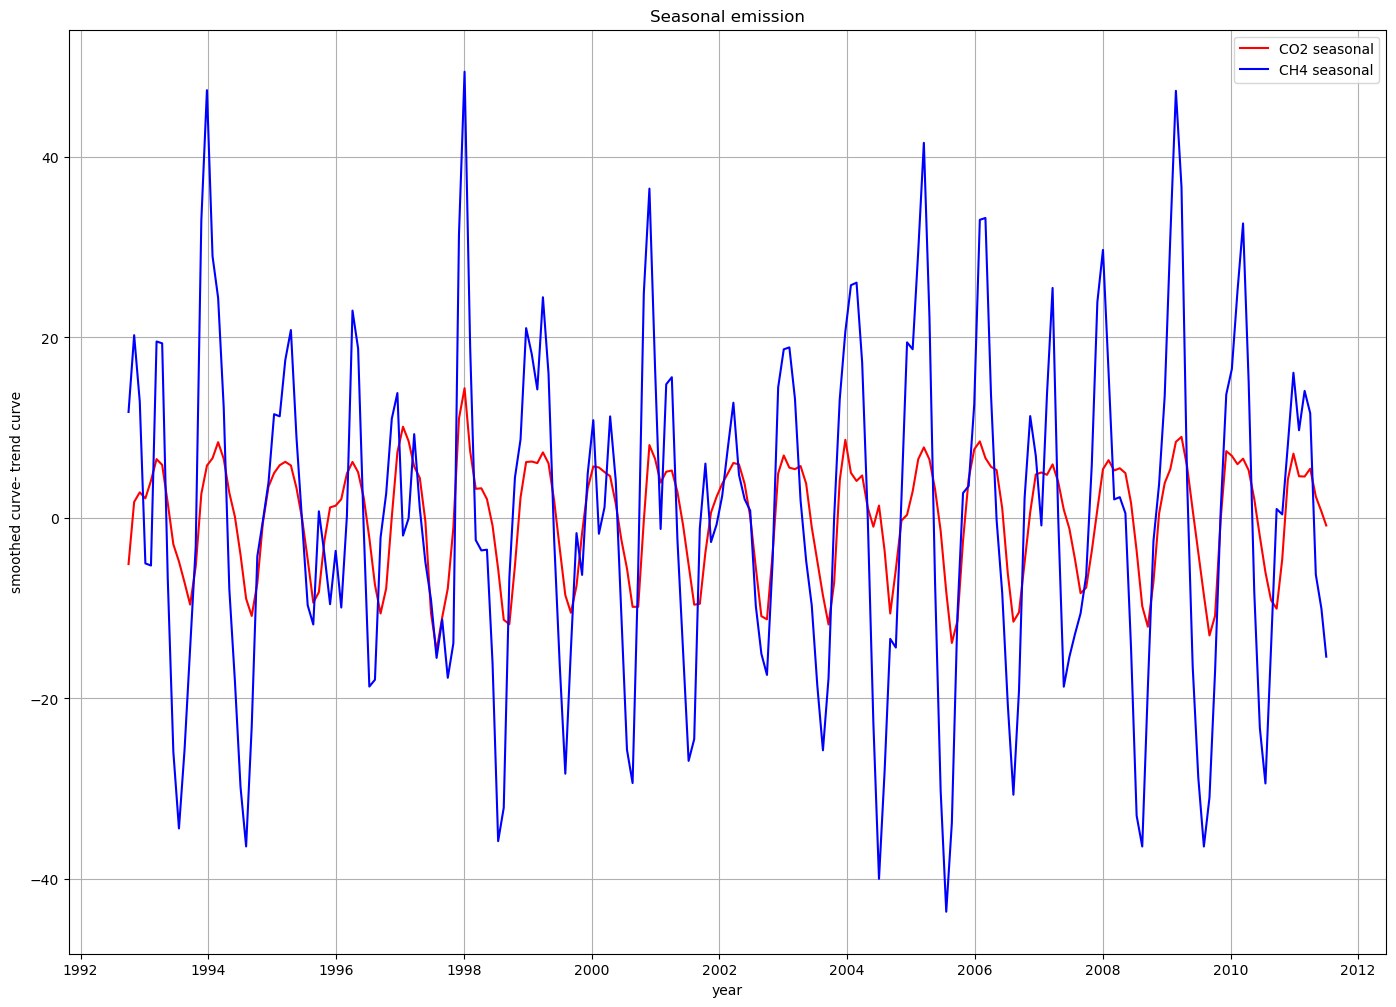

In [95]:
#Plot to compare seasonal change of CO2 and CH4 emission
plt.figure(figsize=(17,12))

plt.plot(co2_df["date"], co2_df["seasonal"], c="red", label="CO2 seasonal")
plt.plot(ch4_df["date"], ch4_df["seasonal"], c="blue", label = "CH4 seasonal")
plt.title("Seasonal emission")
plt.xlabel("year")
plt.ylabel("smoothed curve- trend curve")
plt.grid()
plt.legend()

In [99]:
#Pearson correlation of smoothed, trend and seasonal data to find correlation of CO2 and Ch4 emissions
corr = co2_df["smooth"].corr(ch4_df["smooth"])
trend_corr = co2_df["trend"].corr(ch4_df["trend"])
seasonal_corr = co2_df["seasonal"].corr(ch4_df["seasonal"])
print(f"Smoothed data correlation: {corr:.3f}")
print(f"Trend correlation: {trend_corr:.3f}")
print(f"Seasonal correlation: {seasonal_corr:.3f}")

Smoothed data correlation: 0.829
Trend correlation: 0.943
Seasonal correlation: 0.736


In [97]:
#Machine learning model to predict CO2 emission from CH4 emission
 
X = ch4_df[["smooth", "trend"]]
y = co2_df["smooth"]


model = LinearRegression()
loo = LeaveOneOut()

y_true_arr = y.to_numpy().flatten()

y_true = []
y_pred = []

#I use standard Leave-one-out loop and remove inside the nearby data points of test data point
for train_idx, test_idx in loo.split(X):
        
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    #Building knn model with the reduced training set
    model.fit(X_train, y_train)
    #Making predictions
    pred = model.predict(X_test)
    
    #Appending predictions to list
    y_pred.append(pred[0])
    y_true.append(y_test.values[0])

y_pred = np.array(y_pred)
y_true = np.array(y_true)

In [98]:
# Accuracy
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R-squared: {r2:.3f}")

RMSE: 5.832
R-squared: 0.791


From the pearson correlations we can see that CO2 and CH4 are highly correlated. The trend correlation was 0,94, this means that there are common long term factors which increase the emission of both CO2 and CH4 gases to environment. Seasonal data correlation was 0,73 which means that the seasonal changes affect the emission of both gases similarly.

The leave-one-out regression had accuracy of 0,79 which means that we can use machine learning to predict the changes of one CO2 in the environment by 